# AutoGen によるマルチエージェント実装


### 必要なモジュールのインポート

In [ ]:
import json
import os
import requests
from dotenv import load_dotenv
from autogen_agentchat.teams import SelectorGroupChat
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_agentchat.conditions import (
    TextMentionTermination,
    MaxMessageTermination,
    ExternalTermination,
)
from autogen_agentchat.agents import AssistantAgent
from autogen_core.models import ChatCompletionClient
from autogen_agentchat.messages import (
    TextMessage,
    ToolCallExecutionEvent,
    ToolCallRequestEvent,
)
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient

### 環境変数の読み込み

In [ ]:
load_dotenv()
AI_SEARCH_ENDPOINT = os.getenv("AI_SEARCH_ENDPOINT")
INDEX_NAME = os.getenv("INDEX_NAME")
AI_SEARCH_KEY = os.getenv("AI_SEARCH_KEY")
AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
DEPLOYMENT_NAME = os.getenv("DEPLOYMENT_NAME")
EMBEDDING_MODEL = os.getenv("EMBEDDING_MODEL")
AI_SEARCH_CRED = os.getenv("AI_SEARCH_CRED")
LOGIC_APPS = os.getenv("LOGIC_APPS")

## product_search_agent の作成 (保険商品案内エージェント)

まず、Azure AI Search のクライアントを定義します。

In [ ]:
search_client = SearchClient(
    endpoint=AI_SEARCH_ENDPOINT,
    index_name=INDEX_NAME,
    credential=AzureKeyCredential(AI_SEARCH_KEY),
)

演習1のシングルエージェント実装の際に用いた関数を定義します。\
nonewlines 関数は整形のための関数なので、ツールには含めません。\
Azure AI Search のインデックスを検索する product_search 関数を定義します。

In [ ]:
def nonewlines(s: str) -> str:
    return s.replace("\n", " ").replace("\r", " ").replace("[", "【").replace("]", "】")


# Azure AI Search による検索
def product_search(query: str) -> str:
    """
    保険の商品に関する質問に関して、Azure AI Search の検索結果を返します。

    :param query (str): 保険の商品を検索する際のクエリ
    :rtype: str

    :return: JSON 文字列の検索結果の情報
    :rtype: str
    """

    results = search_client.search(
        search_text=query,
        query_type="semantic",  # セマンティック検索を有効化
        semantic_configuration_name=f"{INDEX_NAME}-semantic-configuration",  # セマンティック検索用の構成名（環境に合わせて変更
        top=3,  # 上位5件を取得（必要に応じて変更）
    )
    context = [nonewlines(doc["chunk"]) for doc in results]
    context_json = json.dumps({"context": context})
    print(context_json)
    return context_json

product_search_agent に登録するツールを `tools_product` として登録します。\
演習1で確認した Grounding with Bing Search および Code Interpreter 使用しません。
今回はツールとしては登録しているのは1つのみですが、この記述に倣ってツールを増やすことが可能です。

In [ ]:
tools_product = [product_search]

[演習3-0](../handson-textbook/ex3.md#演習-3-0-autogen-について) の項目で確認した通り、今回は各エージェントを下記のようなモデルクライアントを引数とした関数でインスタンス化し、呼び出せるようにしています。

```python
def agent_name(model_client: ChatCompletionClient) -> AssistantAgent:
    agent = AssistantAgent(
        name="agent_name",
        description="エージェントの役割や呼び出せるツールを自然言語で明記します",
        model_client=model_client,
        tools = tools, # エージェントが呼び出せるツール
        system_message="""システムメッセージや指示をここで定義します""",
    )
    return agent
```

従って product_search_agent は次のように定義します。

In [ ]:

def product_search_agent(model_client: ChatCompletionClient) -> AssistantAgent:
    agent = AssistantAgent(
        name="ProductSearchAgent",
        description="顧客のデータを確認し、保険の契約状況と担当者を確認するエージェント。さらにユーザーからリクエストがあったばあい、ユーザーの担当者に連絡をする。",
        model_client=model_client,
        tools=tools_product,
        system_message="""json形式でかえしてください""",
    )
    return agent

## contract_lookup_agent の作成 (契約管理エージェント)

product_search_agent と同様に、演習2で作成した契約管理エージェントをベースにします。\
ユーザーデータを検索する contract_lookup 関数を定義します。

In [ ]:
def contract_lookup(user_id: int) -> str:
    # 便宜上一旦ハードコードしています
    """
    ユーザーIDに基づいてユーザー情報を JSON 文字列で返す

    :param user_id (int): ユーザーのID
    :rtype: int

    :return: JSON 文字列のユーザー情報.
    :rtype: str
    """
    mock_users = {
        1234: {
            "name": "佐藤太郎",
            "tel": "090-0000-0000",
            "email": "sato@example.com",
            "staff_email": "xxxxxxxx@example.com",
            "plan": "安心保障プラン",
        },
        5679: {
            "name": "鈴木花子",
            "tel": "080-1111-1111",
            "email": "suzuki@example.com",
            "staff_email": "xxxxxxxx@example.com",
            "plan": "学資サポートプラン",
        },
        4321: {
            "name": "田中次郎",
            "tel": "090-2222-2222",
            "email": "tanaka@example.com",
            "staff_email": "xxxxxxxx@example.com",
            "plan": "シニアライフプラン",
        },
    }
    user_info = mock_users.get(user_id, {"error": "User not found."})
    return json.dumps({"user_info": user_info})




演習2 で行ったとおり CosmosDB を検索する関数でも構いませんが、その場合は環境変数の読み込みを追記し、以下の関数にしてください。
``` python
URL = os.getenv("ACCOUNT_URI")
KEY = os.getenv("ACCOUNT_KEY")

def contract_lookup(user_id: int) -> str:
    """
    ユーザーIDに基づいてユーザー情報を JSON 文字列で返します。ユーザー情報は変更しないでください。

    :param user_id (int): ユーザーのID
    :rtype: int

    :return: JSON 文字列のユーザー情報.
    :rtype: str
    """
    # ユーザー情報を取得するためのクエリ
    queryText = f'SELECT * FROM users u WHERE u.id = "{user_id}"'

    # Cosmos DB からユーザー情報を取得
    results = container.query_items(
        query=queryText,
        enable_cross_partition_query=True,
    )

    items = [item for item in results]
    output = items[0] if items else {}

    return json.dumps(output)

```

Logic Apps を呼び出す関数も同様に定義します。

In [ ]:
def send_email(customer: str, staff_email: str, inquiry: str) -> str:
    """
    お客様から担当者のメールアドレスにお問い合わせがあったことを通知

    :param customer (str): お客様の名前
    :rtype: str

    :param staff_email (str) : 担当者のメールアドレス
    :rtype: str

    :param inquiry (str) : 保険に関するお問い合わせ内容
    :rtype: str

    :return: JSON 文字列のユーザー情報.
    :rtype: str
    """
    headers = {"Content-Type": "application/json"}
    payload = {"customer": customer, "inquiry": inquiry, "staff_email": staff_email}

    endpoint_url = LOGIC_APPS

    try:
        response = requests.post(
            endpoint_url, headers=headers, data=json.dumps(payload)
        )
        response.raise_for_status()
        status = json.dumps({"status": "メールで通知が完了しました"})
        return status
    except requests.exceptions.RequestException as err:
        print(f"エラー: {err}")
        return json.dumps({"status": "メールで通知に失敗しました"})

contract_lookup_agent に渡すツールは、`tools_contract` として定義します。

In [ ]:
tools_contract = [contract_lookup, send_email]

同様に contract_lookup_agent を作成するための関数を定義します。

In [ ]:
def contract_lookup_agent(model_client: ChatCompletionClient) -> AssistantAgent:
    agent = AssistantAgent(
        name="ContractLookupAgent",
        description="顧客のデータを確認し、保険の契約状況と担当者を確認するエージェント。さらにユーザーからリクエストがあった場合、ユーザーの担当者に連絡をする。",
        model_client=model_client,
        tools=tools_contract,
        system_message="""丁寧に返してください""",
    )
    return agent

## summary_agent の作成（会話要約エージェントの作成）
次に summary_agent を作成するための関数を定義します。このエージェントは、エージェント同士の回答を要約して、最終回答を生成するエージェントです。

後述しますが、AutoGen のマルチエージェント実装では、タスクの終了条件を指定する必要があります。 [8 つの組み込みの終了条件](https://microsoft.github.io/autogen/stable/user-guide/agentchat-user-guide/tutorial/termination.html#)があり、今回はタスクが完了したと判定場合に "TERMINATE" という文字列を生成させることで終了判定をします。従って、summary_agent.py の要件は以下です。

- 要約エージェントはマルチエージェントの会話の終了条件となる、`"TERMINATE"`という文字列を最後に生成させます
- 要約エージェントでは、tool の呼び出しは行いません
- これまでの会話履歴を要約し、最終回答としてまとめます


In [ ]:
def summary_agent(model_client: ChatCompletionClient) -> AssistantAgent:

    summary_agent = AssistantAgent(
        name="SummaryAgent",
        description="これまでの会話履歴を要約する AI アシスタント",
        model_client=model_client,
        system_message="""
あなたのタスクは、他の team members が収集した情報をもとに、これまでの会話履歴の要約を作成することです。

## 回答ルール

- ユーザーからの質問に対して、他の team member が収集した情報を使って適切な回答を作成してください。
- 作成後、最終回答の文章の最後に "TERMINATE" と入力して、タスクを完了します。
""",
    )

    return summary_agent

## planner_agent の作成（計画を立てるエージェント）
ここまでで、契約DBを検索するエージェント、商品データを検索するエージェント、要約エージェントができました。\
最後に、ユーザーからの入力に対して、タスクを完了するために必要な計画を立てる planner_agent を作成します。\
ここでは特に、システムプロンプトが重要になります。どんなエージェントが、それぞれどのような役割で、何ができるエージェントなのかを記述します。

In [ ]:
def planner_agent(model_client) -> AssistantAgent:
    agent = AssistantAgent(
        name="PlannerAgent",
        description="与えられたタスクを完了するためのサブタスクを計画する Agent。計画を立てるだけでサブタスクの実行は行いません。",
        model_client=model_client,
        system_message="""ユーザーの質問を適切に回答するためのサブタスクを計画する AI アシスタントです。

- あなたはサブタスクの実行をしてはいけません。サブタスクの計画を作成することのみがあなたの役割です。
- サブタスクを作成するためのあなたの team members は以下です。:
  - contract_lookup_agent: ユーザーの保険加入状況データベースを検索して、回答を行うエージェント。ユーザーの担当者に連絡を送ることができます。
  - product_search_agnet: 保険の商品について、商品説明の資料を検索して、回答を行うエージェント。
  - SummaryAgent: 他の team members からの情報をもとにユーザーへ最終回答を作成・校正を実行することができます。

## サブタスクの計画方法

- あなたの役割は、team members を使って出張計画を作成するためのサブタスクを計画することです。
- サブタスクの実行は必ず team mebers に委任して行います。
- サブタスクの最後は、必ず SummaryAgent に対して、ユーザーへ回答するための出張計画の作成を依頼します。

サブタスクの計画は以下のフォーマットで行います:

1. <agent> : <task>
2. <agent> : <task>
...


## "計画" について
最後に Summary Agent にこれまでの会話履歴の要約を依頼します。
""",
    )

    return agent

## Selector Group Chat の作成
ここまでで、以下の4つのエージェントを作成するための関数ができました。
1. product_search_agent
    - 保険商品のデータを検索
    - Tool : Azure AI Search 
1. contract_lookup_agent
    - ユーザーの契約情報を検索
    - Tool : User Data (もしくはCosmosDB) を検索する関数
    - Tool : Logic Apps
1. summary_agent
    - 会話の要約を行う
1. planer_agent
    - 与えられたタスクから計画を行う

ここからは、作成した4つのエージェントのオーケストレーションを行う、 Group Chat を作成していきます。

まずは各エージェントに渡す Azure OpenAI のモデルクライアントを定義します。\
※ 今回は AutoGen のバージョンを 0.4.7 に指定しているため、autogen_ext.models.openai モジュールの [AzureOpenAIChatCompletionClient](https://microsoft.github.io/autogen/0.4.7/reference/python/autogen_ext.models.openai.html#autogen_ext.models.openai.AzureOpenAIChatCompletionClient) を使っています。執筆時最新の AutoGen 0.5系の場合は [AzureAIChatCompletionClient](https://microsoft.github.io/autogen/stable/reference/python/autogen_ext.models.azure.html#module-autogen_ext.models.azure) を用います。


In [ ]:
# Model Client の定義
aoai_client = AzureOpenAIChatCompletionClient(
    azure_deployment=DEPLOYMENT_NAME,
    model="gpt-4o",
    api_key=AZURE_OPENAI_KEY,
    api_version="2025-01-01-preview",
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
)

モデルクライアントの定義を引数に渡すことで各エージェントを作成します。

In [ ]:
planner = planner_agent(aoai_client)
product_search = product_search_agent(aoai_client)
contract_lookup = contract_lookup_agent(aoai_client)
summary = summary_agent(aoai_client)

## Selector Group Chat のプロンプト

Selector Group Chat 作成時に指定するプロンプトとして以下を定義します。プロンプトには次のようなプレースホルダーを使用することができます：​

|プレースホルダー|説明|
|---------------|---|
|{roles}|各エージェントの名前とその説明が挿入されます。|
|{participants}|参加しているエージェントの名前のリストが挿入されます。|
|{history}|これまでの会話履歴が挿入されます。​|

In [ ]:
selector_prompt = """あなたのタスクは、会話の状況に応じて次のタスクを実行する role を選択することです。
## 次の話者の選択ルール

各 role の概要以下です。

{roles}

次のタスクに選択可能な participants は以下です。

{participants}

以下のルールに従って、次のを選択してください。

- 会話履歴を確認し、次の会話に最適な role を選択します。role name のみを返してください。
- role は1つだけ選択してください。
- 他の role が作業を開始する前に、"PlannerAgent" にタスクを割り当て、サブタスクを計画してもらうことが必要です。
  - PlannerAgent はサブタスクの計画のみを行います。サブタスクの作業を依頼してはいけません。
- PlannerAgent が計画したサブタスクに応じて、role を選択します。
- タスクを完了するための必要な情報が揃ったと判断したら "SummaryAgent" に最終回答の作成を依頼します。

## 会話履歴

{history}
"""

AutoGen には 無限ループを防止するため [8 つの組み込みの終了条件](https://microsoft.github.io/autogen/stable/user-guide/agentchat-user-guide/tutorial/termination.html#)が定義されています。終了条件は OR 条件で指定できるのが便利です。 \
今回は「応答に "TERMINATE" が含まれる」もしくは「最大生成メッセージ数が 10」もしくは「外部からプログラム的に終了させる」という条件にしています。

In [ ]:
termination_condition = TextMentionTermination("TERMINATE") | MaxMessageTermination(10) | ExternalTermination()

## 各エージェントをまとめる team の作成
各エージェントの作成、終了条件の定義、Selector Group Chat に指定するプロンプトの作成ができたので、次のコードで team を作成します。
allow_repeated_speaker は1つのエージェントが続けて会話ができないように指定しています。


In [ ]:
team = SelectorGroupChat(
    [
        planner,
        product_search,
        contract_lookup,
        summary,
    ],
    model_client=aoai_client,
    termination_condition=termination_condition,
    selector_prompt=selector_prompt,
    allow_repeated_speaker=False,
)

実行は team の実行は ```team.run_stream(task="タスクの内容") ``` で行われます。

ここで、次の clean_console 関数は、team の [`run_stream(task=task)`](https://microsoft.github.io/autogen/0.4.7/reference/python/autogen_agentchat.teams.html#autogen_agentchat.teams.BaseGroupChat.run_stream) メソッドの途中処理をコンソール上に見やすく表示させるための関数です。

In [ ]:
async def clean_console(stream):
    async for message in stream:
        if isinstance(message, TextMessage):
            print(
                f"\n ----------------: {message.source}----------------: \n {message.content}"
            )
        elif isinstance(message, ToolCallRequestEvent):
            print(
                f"\n ----------------: {message.source}----------------: \n 呼び出すツール: {message.content[0].name} \n パラメータ: {message.content[0].arguments}"
            )
        elif isinstance(message, ToolCallExecutionEvent):
            print(
                f"\n ----------------: {message.source}----------------: \n ツール呼び出し結果: {message.content[0].content.encode().decode('unicode_escape')} "
            )

それでは実際の挙動を見ていきましょう。\
`"ユーザーID 1234 の人の加入しているプランを調べ、プランの詳細も調べて教えて"` といったタスクを与えます。

In [ ]:
task = "ユーザーID 1234 の人の加入しているプランを調べ、プランの詳細も調べて教えて"
await clean_console(team.run_stream(task=task))

summary_agent によって最終回答が作成され、終了条件の TERMINAL が生成されると、終了判定がされて team での会話が終了します。

処理としては次のようなシーケンス図となります。

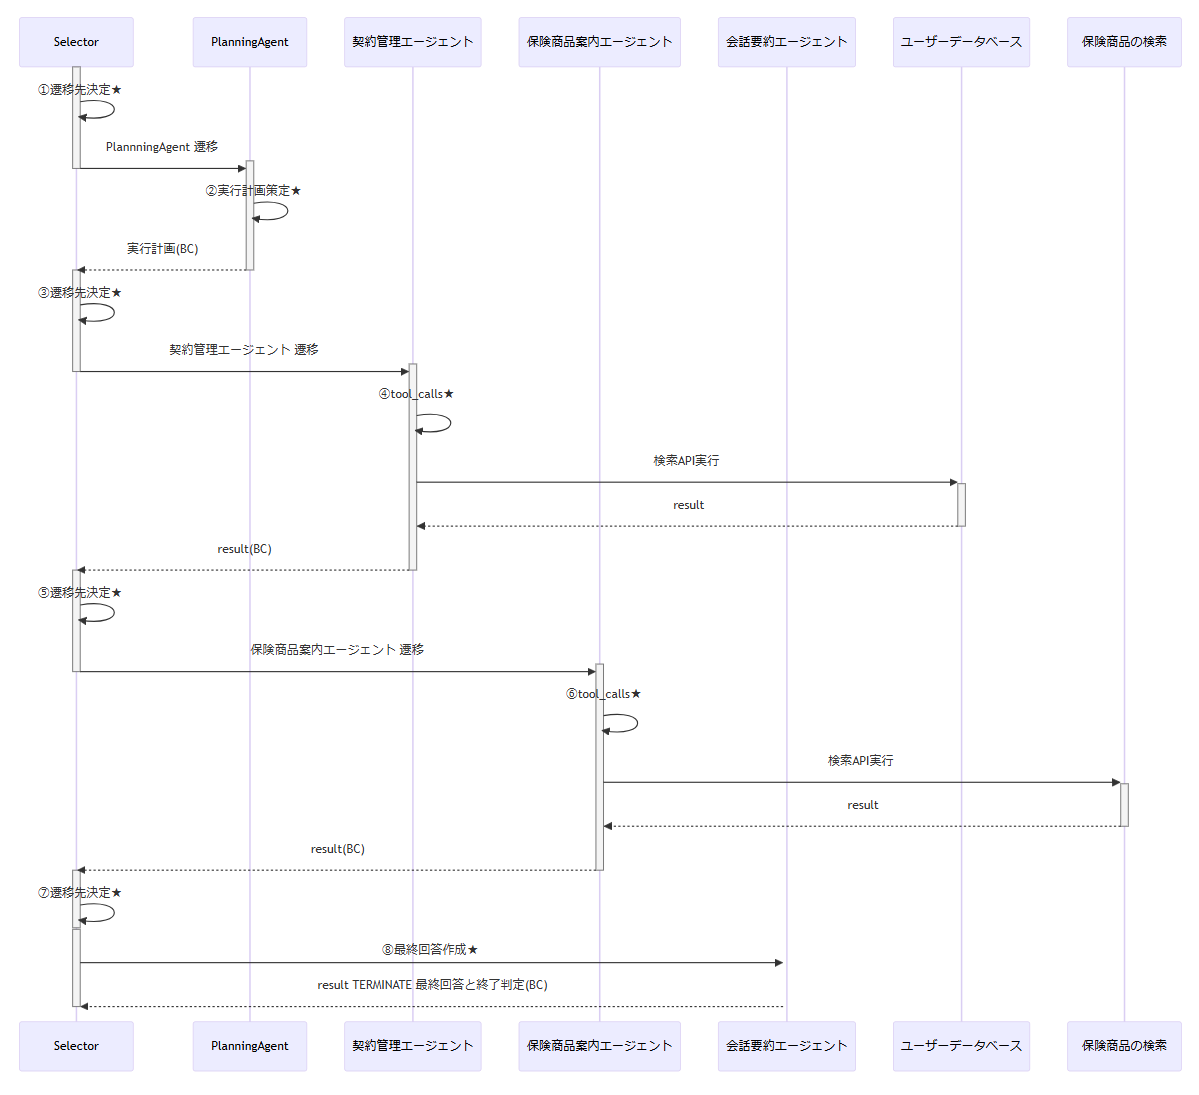

別のタスクを与えて試していただくことも可能ですが、run_stream() で返される非同期ジェネレーターが正しく終了されない場合、
```
 ValueError: The team is already running, it cannot run again until it is stopped.　
```
というエラーが出る場合があります。その際は次のコードセルを実行することで、team を強制終了させることができます。終了させた後に、`team = SelectorGroupChat(...)` のコードセルから再度実行してみてください。

In [ ]:
# team を強制終了
ExternalTermination().set()